In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [3]:
train_data = torchvision.datasets.ImageFolder(
    root="Dataset/training",
    transform=train_transform
)

test_data = torchvision.datasets.ImageFolder(
    root="Dataset/testing",
    transform=test_transform
)

trainloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

In [4]:
classes = train_data.classes
print("Classes:", classes)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224)) 
        self.fc1 = nn.Linear(self._to_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def convs(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self._to_linear is None:
            self._to_linear = x.view(-1).shape[0]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
writer = SummaryWriter("runs/brain_tumor")

images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid)
writer.add_graph(net, images)

In [7]:
epochs = 10
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for images, labels in trainloader:
        optimizer.zero_grad() # reset gradients
        outputs = net(images) # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backpropagation
        optimizer.step() # update weights
        
        running_loss += loss.item() # accumulate loss
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0) # total samples
        correct += (predicted == labels).sum().item() # correct predictions
    
    acc = 100 * correct / total
    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.3f}, Train Acc: {acc:.2f}%")
    
    writer.add_scalar("Loss/train", avg_loss, epoch)
    writer.add_scalar("Accuracy/train", acc, epoch)

    net.eval()
    val_loss_running, val_correct, val_total = 0.0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss_running += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    val_loss = val_loss_running / len(testloader)
    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.3f}, Validation Acc: {val_acc:.2f}%")

    writer.add_scalar("Loss/validation", val_loss, epoch)
    writer.add_scalar("Accuracy/validation", val_acc, epoch)

Epoch 1/10, Loss: 0.684, Train Acc: 72.67%
Validation Loss: 0.476, Validation Acc: 79.48%
Epoch 2/10, Loss: 0.366, Train Acc: 85.99%
Validation Loss: 0.308, Validation Acc: 87.64%
Epoch 3/10, Loss: 0.231, Train Acc: 91.19%
Validation Loss: 0.215, Validation Acc: 91.38%
Epoch 4/10, Loss: 0.152, Train Acc: 94.08%
Validation Loss: 0.155, Validation Acc: 94.28%
Epoch 5/10, Loss: 0.103, Train Acc: 96.39%
Validation Loss: 0.146, Validation Acc: 94.66%
Epoch 6/10, Loss: 0.075, Train Acc: 97.39%
Validation Loss: 0.225, Validation Acc: 93.82%
Epoch 7/10, Loss: 0.064, Train Acc: 97.79%
Validation Loss: 0.138, Validation Acc: 95.88%
Epoch 8/10, Loss: 0.045, Train Acc: 98.81%
Validation Loss: 0.096, Validation Acc: 97.25%
Epoch 9/10, Loss: 0.035, Train Acc: 98.70%
Validation Loss: 0.139, Validation Acc: 96.95%
Epoch 10/10, Loss: 0.028, Train Acc: 99.05%
Validation Loss: 0.108, Validation Acc: 97.10%


In [8]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nPerformance Metrics:")
print(f"Accuracy:  {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall:    {rec*100:.2f}%")
print(f"F1-score:  {f1*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes))


Performance Metrics:
Accuracy:  97.10%
Precision: 97.26%
Recall:    97.10%
F1-score:  97.09%

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.90      0.94       300
  meningioma       0.91      0.98      0.94       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



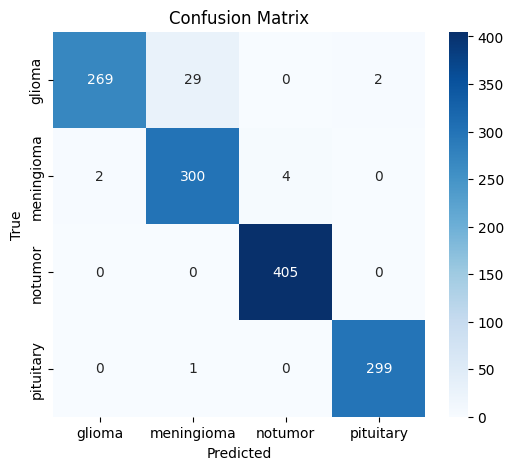

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [10]:
torch.save(net.state_dict(), "model.pth")
print("Model saved as model.pth")

Model saved as model.pth


In [ ]:
writer.close()